In [5]:
import numpy as np
from skimage import data
from skimage . color import rgb2gray
import matplotlib . pyplot as plt
from mpl_toolkits . mplot3d import Axes3D
import cv2 as cv # librairie OpenCV
from tqdm import tqdm
from numba import njit
import time
from sklearn.linear_model import RANSACRegressor # modèle de RANSAC implémenté dans sklearn

In [6]:
@njit
def SAD(block1, block2):
    return np.abs(block1 - block2).sum()

@njit
def SSD(block1, block2):
    return (np.abs(block1 - block2)**2).sum()

@njit
def ZSSD(patch1, patch2):
    mean1 = np.mean(patch1)
    mean2 = np.mean(patch2)
    # Subtract the mean from patch1 and patch2
    patch1_normalized = patch1 - mean1
    patch2_normalized = patch2 - mean2
    # Compute the squared differences
    squared_diff = np.square(patch1_normalized - patch2_normalized)
    # Calculate the sum of squared differences
    zssd_score = np.sum(squared_diff)
    return zssd_score

@njit
def ZNSSD(patch1, patch2):
    mean1 = np.mean(patch1)
    mean2 = np.mean(patch2)

    patch1_normalized = (patch1 - mean1) / np.linalg.norm(patch1 - mean1)
    patch2_normalized = (patch2 - mean2) / np.linalg.norm(patch1 - mean1)

    squared_diff = np.square(patch1_normalized - patch2_normalized)
    nzssd_score = np.sum(squared_diff)

    return nzssd_score

In [7]:
@njit
def block_matching(Iref, Isearch, N, maxdisp, similarity):
    disp = np.zeros_like(Iref)
    margin = N//2
    for i in np.arange(margin,Iref.shape[0] - margin):
        for j in np.arange(margin, Iref.shape[1] - margin):
            ref_block = Iref[i-margin:i+margin+1,j-margin:j+margin+1]
            min_sad=np.inf
            min_pos=0
            for x_dec in np.arange(0, maxdisp):
                new_x = j-x_dec
                if new_x >= margin:
                    search_block = Isearch[i-margin:i+margin+1, new_x-margin:new_x+margin+1]
                    sad=similarity(ref_block, search_block)
                    if sad < min_sad:
                        min_sad=sad
                        min_pos=x_dec
            disp[i,j]=min_pos
    return disp

In [8]:
# Measure the execution time
@njit
def mode_filter(img, N=5):
    filtered_img = np.zeros_like(img)
    pas = N//2
    for i in np.arange(pas,img.shape [0]-pas):
        for j in np.arange(pas, img.shape [1]-pas):
            block = img[i-pas:i+pas+1,j-pas:j+pas+1]
            occ = {val:0 for val in set(block.flatten())}
            for val in block.flatten():
                occ[val]+=1
                
            max_k=0
            max_val=0
            for key, value in occ.items():
                if value > max_val:
                    max_k=key
                    max_val=value
            filtered_img[i,j]=max_k
    return filtered_img


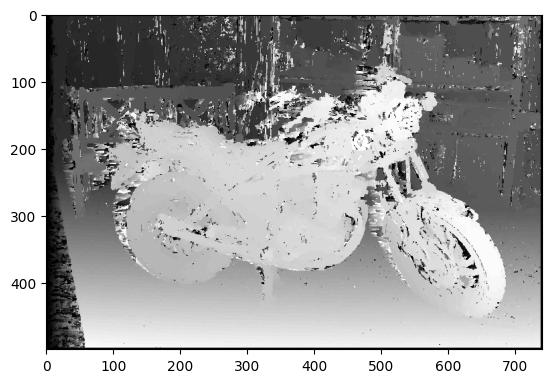

In [15]:
Ig, Id, gt = data.stereo_motorcycle()
maxdisp = 60
N = 5
bsize = (3, 3) # size of the kernel for blurring the images and median filtering.

disp = block_matching(rgb2gray(Ig), rgb2gray(Id), N, maxdisp, ZNSSD)
plt.imshow(disp, cmap="gray")

Execution time: 1.18406343460083 seconds


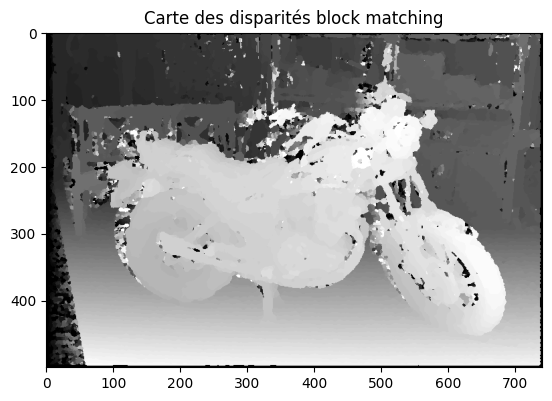

In [16]:
# test la fonction
start_time = time.time()
disp = mode_filter(disp, N)
end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")
plt. figure ()
plt. imshow ( disp , cmap = "gray" )
plt. title ( "Carte des disparités block matching" )
plt.show()

Nombre de points sans disparité : 10833


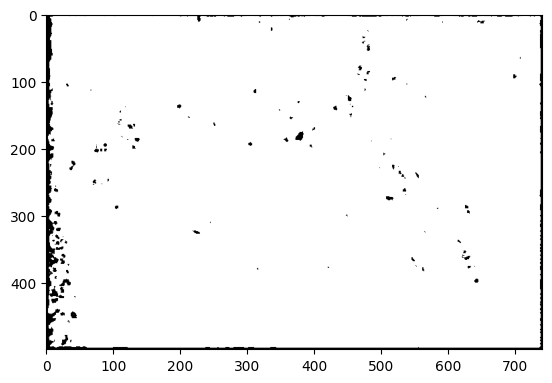

In [17]:
res1 = disp.copy()

mask = np.where((res1 > 0) & (res1 != -1), 1, 0).astype(bool)
num_no_disparity = np.sum(~mask)

print(f"Nombre de points sans disparité : {num_no_disparity}")
plt.imshow(mask, cmap="gray")

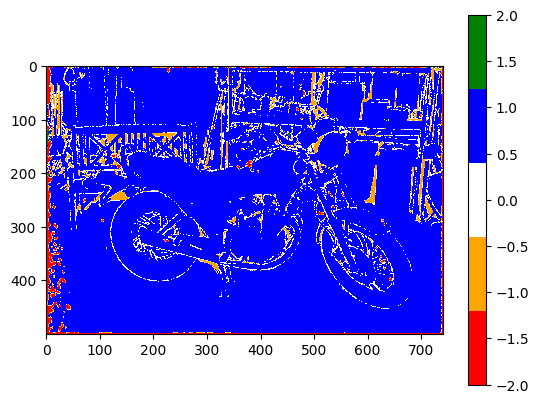

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Définition de la palette de couleurs personnalisée
occcmap = ListedColormap(["red", "orange", "white", "blue", "green"])

# Exemple de matrice de vérité gt et de masque M

M = mask

# Création de la carte d'évaluation des occultations
evaluation_map = np.zeros_like(gt, dtype=np.int8)

evaluation_map[(gt < np.inf) & (M == 1)] = 1  # Vrai négatif
evaluation_map[(gt < np.inf) & (M == 0)] = -2  # Faux positif
evaluation_map[(gt == np.inf) & (M == 1)] = -1  # Faux négatif
evaluation_map[(gt == np.inf) & (M == 0)] = 2  # Vrai positif

# Affichage de la carte d'évaluation des occultations
plt.imshow(evaluation_map, cmap=occcmap)
plt.colorbar()
plt.show()

In [19]:
# Calculer le masque des faux négatifs
false_negatives_mask = (res1 > 0) & (gt == np.inf)

# Compter le nombre de faux négatifs
false_negatives_count = np.count_nonzero(false_negatives_mask)

# Afficher le nombre de faux négatifs
print("Nombre de faux négatifs :", false_negatives_count)

Nombre de faux négatifs : 26548


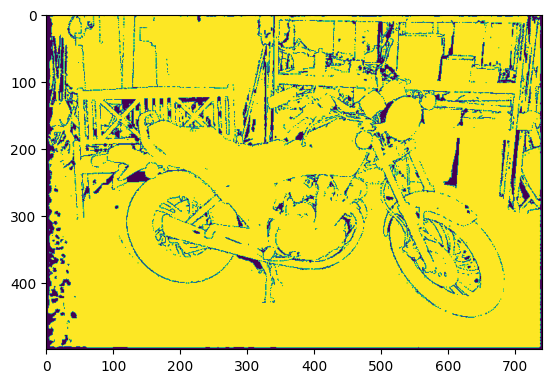

In [20]:
# Calculer le masque des points à considérer
mask_eval = M & (gt < np.inf)

# Afficher le masque des points à considérer
plt.imshow(mask_eval)

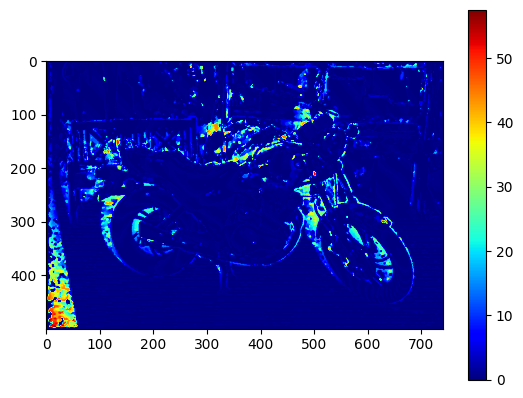

In [21]:
# Calculer la carte des différences absolues
diff_map = np.abs(res1 - gt)

# Fixer à 0 les points hors du masque M_eval
diff_map[~mask_eval] = 0

# Définir les bornes de l'échelle des pseudocouleurs
vmin = 0
vmax = np.max(diff_map)

# Afficher la carte des différences absolues
plt.imshow(diff_map, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.show()

In [22]:
# Sélectionner les valeurs d'erreur de disparité correspondant aux points dans M_eval
errors = diff_map[mask_eval]

# Calculer les mesures d'erreur
mean_error = np.mean(errors)
median_error = np.median(errors)
min_error = np.min(errors)
max_error = np.max(errors)
std_error = np.std(errors)

# Afficher les mesures d'erreur
print("Erreur moyenne de disparité :", mean_error)
print("Erreur médiane de disparité :", median_error)
print("Erreur minimale de disparité :", min_error)
print("Erreur maximale de disparité :", max_error)
print("Écart-type d'erreur de disparité :", std_error)

Erreur moyenne de disparité : 2.5217354323024384
Erreur médiane de disparité : 0.31354331970214844
Erreur minimale de disparité : 0.0
Erreur maximale de disparité : 57.519386291503906
Écart-type d'erreur de disparité : 7.35853257759137


In [23]:
def CorrespondanceStereoDP(imageGauche, imageDroite, coutDisparite):
    largeur = imageGauche.shape[1]
    hauteur = imageGauche.shape[0]

    # Initialisation du tableau de coûts
    tableauCouts = [[0] * largeur for _ in range(hauteur)]

    # Calcul des coûts initiaux pour la première ligne
    for colonne in range(largeur):
        tableauCouts[0][colonne] = coutDisparite(imageGauche[0, colonne], imageDroite[0, colonne])

    # Calcul des coûts pour les autres lignes
    for ligne in range(1, hauteur):
        for colonne in range(largeur):
            minimumCout = float('inf')
            for disparite in range(largeur):
                if colonne - disparite >= 0:
                    cout = coutDisparite(imageGauche[ligne, colonne], imageDroite[ligne, colonne - disparite]) + tableauCouts[ligne - 1][colonne - disparite]
                    if cout < minimumCout:
                        minimumCout = cout
            tableauCouts[ligne][colonne] = minimumCout

    # Rétro-propagation pour trouver la meilleure disparité
    disparites = [[0] * largeur for _ in range(hauteur)]
    ligne = hauteur - 1
    for colonne in range(largeur - 1, -1, -1):
        minimumCout = float('inf')
        meilleureDisparite = 0
        for disparite in range(largeur):
            if colonne + disparite < largeur:
                cout = tableauCouts[ligne][colonne + disparite]
                if cout < minimumCout:
                    minimumCout = cout
                    meilleureDisparite = disparite
        disparites[ligne][colonne] = meilleureDisparite
        ligne -= 1

    return disparites


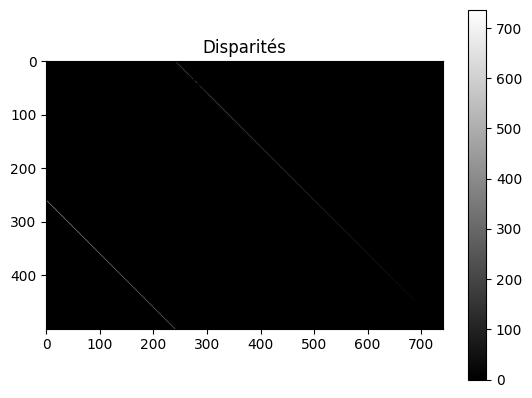

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

# Fonction de coût de disparité (exemple avec la différence absolue)
def coutDisparite(pixelGauche, pixelDroite):
    return np.abs(pixelGauche - pixelDroite)

# Chargement des images stéréo du jeu de données "motorcycle"
Ig, Id, gt = data.stereo_motorcycle()
Ig = rgb2gray(Ig)
Id = rgb2gray(Id)

# Conversion des images en tableaux NumPy
imageGauche = np.asarray(Ig)
imageDroite = np.asarray(Id)

# Appel de la fonction de correspondance stéréo
disparites = CorrespondanceStereoDP(imageGauche, imageDroite, coutDisparite)

# Affichage des disparités
plt.imshow(disparites, cmap='gray')
plt.colorbar()
plt.title('Disparités')
plt.show()
